# Finetuning moondream

This notebook is a modified copy of the original notebook here: https://github.com/vikhyat/moondream/blob/main/notebooks/Finetuning.ipynb

# Install Packages

In [1]:
# Install all necessary libraries
!pip install torch transformers timm einops datasets bitsandbytes accelerate roboflow supervision -q

# !pip install --upgrade pip
# !pip uninstall -y <package_name> && pip install <package_name>

# Downgrade pyarrow to a version compatible with other packages
!pip install pyarrow==14.0.1

# Reinstall bitsandbytes with GPU support
!pip uninstall -y bitsandbytes
!pip install bitsandbytes==0.40.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.
  Using cached pyarrow-14.0.1-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (3.0 kB)
Using cached pyarrow-14.0.1-cp310-cp310-manylinux_2_28_x86_64.whl (38.0 MB)
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 17.0.0
    Uninstalling pyarrow-17.0.0:
      Successfully uninstalled pyarrow-17.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.21.0 requires pyarrow>=15.0.0, but you have pyarrow 14.0.1 which is incompatible.
Found existing installation: bitsan

In [2]:
import torch
import transformers
import timm
import einops
import datasets
import bitsandbytes
import accelerate
import supervision


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cpu.so
/usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32
CUDA SETUP: Loading binary /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cpu.so...


/usr/local/lib/python3.10/dist-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


In [ ]:
if torch.cuda.is_available():
    print(f"GPU is available: {torch.cuda.get_device_name(0)}")
else:
    print("GPU not available, using CPU.")

In [3]:
# Run if you are using flash attention. Make sure to restart your runtime
!pip install flash-attn --no-build-isolation -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 23.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


# Dataset Setup

In [4]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="sEP3nRm2JpsmPIvBV2H1")
project = rf.workspace("practice-h04uc").project("root-canel")
version = project.version(3)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Root-canel-3 in coco:: 100%|██████████| 6672/6672 [00:01<00:00, 3839.22it/s]


In [5]:
import os

# Check if the dataset has been downloaded and list the files
dataset_path = dataset.location
print(f"Dataset downloaded to: {dataset_path}")
print("Listing files in dataset directory:")
print(os.listdir(dataset_path))

Dataset downloaded to: /content/Root-canel-3
Listing files in dataset directory:
['README.roboflow.txt', 'train', 'test', 'README.dataset.txt', 'valid']


In [10]:
from torch.utils.data import Dataset
import json
from PIL import Image
import supervision as sv

class RoboflowDataset(Dataset):
    def __init__(self, dataset_path, split):
        self.split = split

        sv_dataset = sv.DetectionDataset.from_coco(
            f"{dataset_path}/{split}/",
            f"{dataset_path}/{split}/_annotations.coco.json"
        )

        self.dataset = sv_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        CLASSES = ["complete", "incomplete", "required"]

        # Retrieve the image/annotation info from the Supervision DetectionDataset
        image_name, annotations = list(self.dataset.annotations.items())[idx]
        image = self.dataset.images[image_name]

        # Finds the amount of each type of currency there is from the number of annotations there are
        money = {}
        for class_idx, money_type in enumerate(CLASSES):
          count = len(annotations[annotations.class_id == (class_idx+1)]) # Counts the number of annotations with that class
          if count == 0: continue;

          money[money_type] = count

        # Define the prompt/answer
        prompt = f"Provide the count of each tooth endodontic status ({', '.join(CLASSES)}) in the dataset. Format the response as a JSON object, with each endodontic status as the key and its corresponding count as the integer value."
        answer = json.dumps(money, indent=2) # Formats the JSON and makes it the answer

        # Return as the proper format
        return {
            "image": Image.fromarray(image),
            "qa": [
                {
                    "question": prompt,
                    "answer": answer,
                }
            ]
        }

datasets = {
    "train": RoboflowDataset(dataset.location,"train"),
    "val": RoboflowDataset(dataset.location,"valid"),
    "test": RoboflowDataset(dataset.location,"test"),
}

# datasets = {
#     "test": RoboflowDataset(dataset.location,"test"),
# }

In [11]:
# Test loading the first item in the train dataset
sample = datasets["train"][0]
print(sample["qa"][0]["question"])
print(sample["qa"][0]["answer"])
sample["image"].show()  # Display the image

images is deprecated: `DetectionDataset.images` property is deprecated and will be removed in `supervision-0.26.0`. Iterate with `for path, image, annotation in dataset:` instead.


Provide the count of each tooth endodontic status (complete, incomplete, required) in the dataset. Format the response as a JSON object, with each endodontic status as the key and its corresponding count as the integer value.
{
  "complete": 1,
  "incomplete": 1,
  "required": 1
}


Now let's take a look at a sample image from the training set and compare the ground-truth answers
with moondream predictions.

In [12]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# Set the device to 'cuda' if you're using a GPU, otherwise 'cpu'
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# FLASHATTENTION should be None for GPUs that don't support flash attention
FLASHATTENTION = None if DEVICE == "cpu" else "flash_attention" # or set to None if any issues arise

# Use float16 for GPU and float32 for CPU
DTYPE = torch.float32 if DEVICE == "cpu" else torch.float16

MD_REVISION = "2024-04-02"

# Initialize the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("vikhyatk/moondream2", revision=MD_REVISION)
moondream = AutoModelForCausalLM.from_pretrained(
    "vikhyatk/moondream2", revision=MD_REVISION, trust_remote_code=True,
    attn_implementation=FLASHATTENTION,
    torch_dtype=DTYPE, device_map={"": DEVICE}
)


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/318 [00:00<?, ?B/s]

configuration_moondream.py:   0%|          | 0.00/3.39k [00:00<?, ?B/s]

moondream.py:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

vision_encoder.py:   0%|          | 0.00/4.94k [00:00<?, ?B/s]

modeling_phi.py:   0%|          | 0.00/49.4k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.72G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/69.0 [00:00<?, ?B/s]

In [25]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import supervision as sv
import datasets

# Set the device to 'cuda' since you're using a T4 GPU
DEVICE = "cuda"

# FLASHATTENTION should be None for T4 GPU as it doesn't support advanced flash attention features
FLASHATTENTION = None

# Use float16 for GPU to save memory and enhance performance
DTYPE = torch.float16

MD_REVISION = "2024-04-02"

# Initialize the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("vikhyatk/moondream2", revision=MD_REVISION)
moondream = AutoModelForCausalLM.from_pretrained(
    "vikhyatk/moondream2", revision=MD_REVISION, trust_remote_code=True,
    attn_implementation=FLASHATTENTION,
    torch_dtype=DTYPE, device_map={"": DEVICE}
)

# Load a sample from the dataset
sample = datasets['test'][0]

# Print the shape and content of the image and question
print('Image Shape:', sample['image'].shape)
print('Question:', sample['qa'][0]['question'])

# Encode the image and check the encoded output
encoded_image = moondream.encode_image(sample['image'])
print('Encoded Image Shape:', encoded_image.shape)

# Tokenize the question and verify the output
inputs = tokenizer(sample['qa'][0]['question'], return_tensors='pt', padding=True, truncation=True)
print('Tokenized Input:', inputs)

# Attempt to generate an answer
try:
    md_answer = moondream.answer_question(
        encoded_image,
        sample['qa'][0]['question'],
        tokenizer=tokenizer,
    )

    # Plot the image and print the question, ground truth, and model's answer
    sv.plot_image(sample['image'], (3, 3))
    print('Question:', sample['qa'][0]['question'])
    print('Ground Truth:', sample['qa'][0]['answer'])
    print('Moondream:', md_answer)

except IndexError as e:
    print("IndexError:", e)
    print("This error might be related to the `position_ids` or an incorrect input shape.")
    print("Please check the model's documentation or try a different approach.")


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


TypeError: DetectionDataset.from_coco() got an unexpected keyword argument 'image_dir'

In [22]:
correct = 0

for i, sample in enumerate(datasets['test']):
    md_answer = moondream.answer_question(
        moondream.encode_image(sample['image']),
        sample['qa'][0]['question'],
        tokenizer=tokenizer,
    )

    if md_answer == sample['qa'][0]['answer']:
        correct += 1

    if i < 11:
        sv.plot_image(sample['image'], (3,3))
        print('Question:', sample['qa'][0]['question'])
        print('Ground Truth:', sample['qa'][0]['answer'])
        print('Moondream:', md_answer)

print(f"\n\nAccuracy: {correct / len(datasets['test']) * 100:.2f}%")

TypeError: 'module' object is not subscriptable

# Fine-tuning
Let's start setting up hyperparameters for finetuning.

In [ ]:
# Number of times to repeat the training dataset. Increasing this may cause the model to overfit or
# lose generalization due to catastrophic forgetting. Decreasing it may cause the model to underfit.
EPOCHS = 2

# Number of samples to process in each batch. Set this to the highest value that doesn't cause an
# out-of-memory error. Decrease it if you're running out of memory. Batch size 8 currently uses around
# 15 GB of GPU memory during fine-tuning.
BATCH_SIZE = 8

# Number of batches to process before updating the model. You can use this to simulate a higher batch
# size than your GPU can handle. Set this to 1 to disable gradient accumulation.
GRAD_ACCUM_STEPS = 1

# Learning rate for the Adam optimizer. Needs to be tuned on a case-by-case basis. As a general rule
# of thumb, increase it by 1.4 times each time you double the effective batch size.
#
# Source: https://www.cs.princeton.edu/~smalladi/blog/2024/01/22/SDEs-ScalingRules/
#
# Note that we linearly warm the learning rate up from 0.1 * LR to LR over the first 10% of the
# training run, and then decay it back to 0.1 * LR over the last 90% of the training run using a
# cosine schedule.
LR = 3e-5

# Whether to use Weights and Biases for logging training metrics.
USE_WANDB = False


This next block will start the training process.

In [ ]:
from torch.utils.data import DataLoader
from bitsandbytes.optim import Adam8bit
import math
from einops import rearrange
from tqdm import tqdm

ANSWER_EOS = "<|endoftext|>"

# Number of tokens used to represent each image.
IMG_TOKENS = 729

def collate_fn(batch):
    images = [sample['image'] for sample in batch]
    images = torch.stack(moondream.vision_encoder.preprocess(images))
    images = rearrange(images,
                       "b c (h p1) (w p2) -> b (h w) (c p1 p2)",
                       p1=14, p2=14)

    labels_acc = []
    tokens_acc = []

    for sample in batch:
        toks = [tokenizer.bos_token_id]
        labs = [-100] * (IMG_TOKENS + 1)

        for qa in sample['qa']:
            q_t = tokenizer(
                f"\n\nQuestion: {qa['question']}\n\nAnswer:",
                add_special_tokens=False
            ).input_ids
            toks.extend(q_t)
            labs.extend([-100] * len(q_t))

            a_t = tokenizer(
                f" {qa['answer']}{ANSWER_EOS}",
                add_special_tokens=False
            ).input_ids
            toks.extend(a_t)
            labs.extend(a_t)

        tokens_acc.append(toks)
        labels_acc.append(labs)

    max_len = -1
    for labels in labels_acc:
        max_len = max(max_len, len(labels))

    attn_mask_acc = []

    for i in range(len(batch)):
        len_i = len(labels_acc[i])
        pad_i = max_len - len_i

        labels_acc[i].extend([-100] * pad_i)
        tokens_acc[i].extend([tokenizer.eos_token_id] * pad_i)
        attn_mask_acc.append([1] * len_i + [0] * pad_i)

    return (
        images.to(dtype=DTYPE),
        torch.stack([torch.tensor(t, dtype=torch.long) for t in tokens_acc]),
        torch.stack([torch.tensor(l, dtype=torch.long) for l in labels_acc]),
        torch.stack([torch.tensor(a, dtype=torch.bool) for a in attn_mask_acc]),
    )

def compute_loss(batch):
    images, tokens, labels, attn_mask = batch

    images = images.to(DEVICE)
    tokens = tokens.to(DEVICE)
    labels = labels.to(DEVICE)
    attn_mask = attn_mask.to(DEVICE)

    with torch.no_grad():
        img_embs = moondream.vision_encoder.encoder(images)
        img_embs = moondream.vision_encoder.projection(img_embs)

    tok_embs = moondream.text_model.get_input_embeddings()(tokens)
    inputs_embeds = torch.cat((tok_embs[:, 0:1, :], img_embs, tok_embs[:, 1:, :]), dim=1)

    outputs = moondream.text_model(
        inputs_embeds=inputs_embeds,
        labels=labels,
        attention_mask=attn_mask,
    )

    return outputs.loss

def lr_schedule(step, max_steps):
    x = step / max_steps
    if x < 0.1:
        return 0.1 * LR + 0.9 * LR * x / 0.1
    else:
        return 0.1 * LR + 0.9 * LR * (1 + math.cos(math.pi * (x - 0.1))) / 2

dataloaders = {
    "train": DataLoader(
        datasets["train"],
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=collate_fn,
    ),
    "val": DataLoader(
        datasets["val"],
        batch_size=BATCH_SIZE,
        collate_fn=collate_fn,
    ),
}

moondream.text_model.train()
moondream.text_model.transformer.gradient_checkpointing_enable()

total_steps = EPOCHS * len(dataloaders["train"]) // GRAD_ACCUM_STEPS
optimizer = Adam8bit(
    [
        {"params": moondream.text_model.parameters()},
    ],
    lr=LR * 0.1,
    betas=(0.9, 0.95),
    eps=1e-6
)

if USE_WANDB:
    import wandb
    wandb.init(
        project="moondream-ft",
        config={
            "EPOCHS": EPOCHS,
            "BATCH_SIZE": BATCH_SIZE,
            "GRAD_ACCUM_STEPS": GRAD_ACCUM_STEPS,
            "LR": LR,
        }
    )

i = 0
for epoch in range(EPOCHS):
    for batch in tqdm(dataloaders["train"], desc=f"Epoch {epoch + 1}/{EPOCHS}"):
        i += 1

        loss = compute_loss(batch)
        loss.backward()

        if i % GRAD_ACCUM_STEPS == 0:
            optimizer.step()
            optimizer.zero_grad()

            lr = lr_schedule(i / GRAD_ACCUM_STEPS, total_steps)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr

        if i % 100 == 0 and USE_WANDB:
            # Calculate validation loss
            val_loss = 0
            for val_batch in tqdm(dataloaders["val"], desc="Validation"):
                with torch.no_grad():
                    val_loss += compute_loss(val_batch).item()
            val_loss /= len(dataloaders["val"])

        if USE_WANDB:
            wandb.log({
                "loss/train": loss.item(),
                "lr": optimizer.param_groups[0]['lr']
            } | ({"loss/val": val_loss} if i % 100 == 0 else {}))

if USE_WANDB:
    wandb.finish()

Epoch 1/1: 100%|██████████| 38/38 [01:43<00:00,  2.73s/it]


In [ ]:
moondream.save_pretrained("checkpoints/moondream2-coincounter")

In [ ]:
import shutil
shutil.make_archive("coincounter_zip", 'zip', "checkpoints/moondream2-coincounter")

KeyboardInterrupt: 

# Evaluation
Now that training has completed, let's inspect a few samples and calculate accuracy.

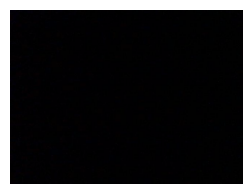

Ground Truth: {}
Moondream: {}


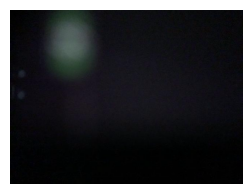

Ground Truth: {}
Moondream: {}


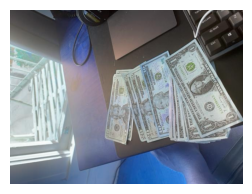

Ground Truth: {
  "five": 2,
  "one": 6,
  "ten": 1,
  "twenty": 4
}
Moondream: {
  "one": 1,
  "ten": 1,
  "twenty": 1
}


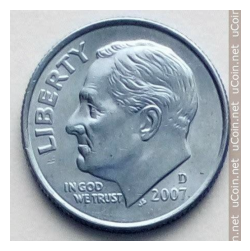

Ground Truth: {
  "dime": 1
}
Moondream: {
  "dime": 1
}


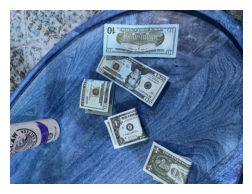

Ground Truth: {
  "one": 2,
  "ten": 1,
  "twenty": 2
}
Moondream: {
  "one": 1,
  "ten": 1,
  "twenty": 1
}


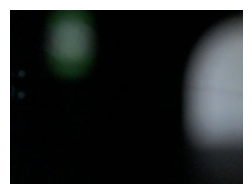

Ground Truth: {}
Moondream: {}


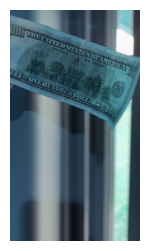

Ground Truth: {
  "hundred": 1
}
Moondream: {
  "hundred": 1
}


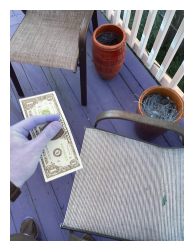

Ground Truth: {
  "one": 1
}
Moondream: {
  "one": 1
}


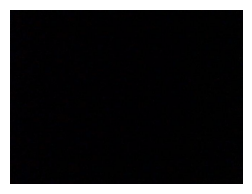

Ground Truth: {}
Moondream: {}


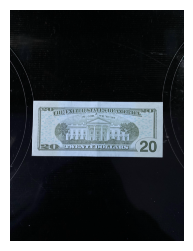

Ground Truth: {
  "twenty": 1
}
Moondream: {
  "twenty": 1
}


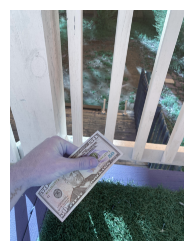

Ground Truth: {
  "fifty": 1
}
Moondream: {
  "fifty": 1
}


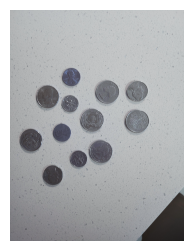

Ground Truth: {
  "dime": 2,
  "nickel": 2,
  "penny": 2,
  "quarter": 6
}
Moondream: {
  "dime": 2,
  "nickel": 2,
  "penny": 2,
  "quarter": 6
}


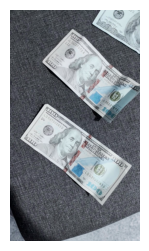

Ground Truth: {
  "hundred": 3
}
Moondream: {
  "hundred": 2
}


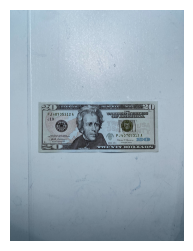

Ground Truth: {
  "twenty": 1
}
Moondream: {
  "twenty": 1
}


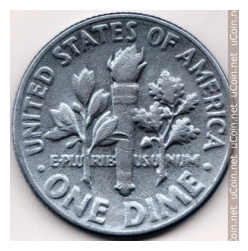

Ground Truth: {
  "dime": 1
}
Moondream: {
  "dime": 1
}


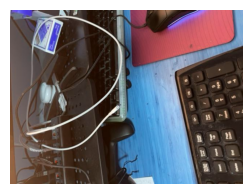

Ground Truth: {}
Moondream: {}


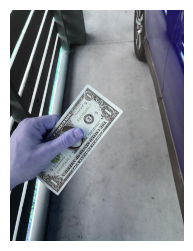

Ground Truth: {
  "one": 1
}
Moondream: {
  "one": 1
}


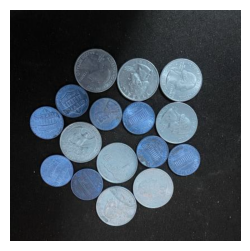

Ground Truth: {
  "penny": 8,
  "quarter": 8
}
Moondream: {
  "penny": 8,
  "quarter": 8
}


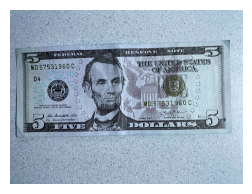

Ground Truth: {
  "five": 1
}
Moondream: {
  "five": 1
}


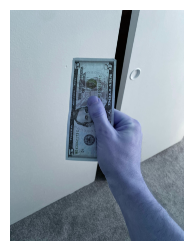

Ground Truth: {
  "five": 1
}
Moondream: {
  "five": 1
}


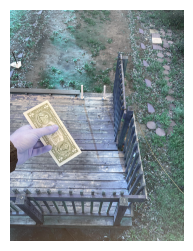

Ground Truth: {
  "one": 1
}
Moondream: {
  "one": 1
}


Accuracy: 83.97%


In [ ]:
moondream.eval()

correct = 0

for i, sample in enumerate(datasets['test']):
    md_answer = moondream.answer_question(
        moondream.encode_image(sample['image']),
        sample['qa'][0]['question'],
        tokenizer=tokenizer,
    )

    if md_answer == sample['qa'][0]['answer']:
        correct += 1

    if i < 21:
        sv.plot_image(sample['image'], (3,3))
        print('Ground Truth:', sample['qa'][0]['answer'])
        print('Moondream:', md_answer)

print(f"\n\nAccuracy: {correct / len(datasets['test']) * 100:.2f}%")

# Util
For display purposes

In [ ]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)